In [1]:
import pandas as pd
import datetime
from dateutil import parser

In [2]:
# load data
df = pd.read_csv("MOTNetwerk.csv", sep=";")
df.head()

,#Indiener,Partij Indiener,Medeindiener,Partij Medeindiener,datum motie,URL naar motie
0,S. Faber,CDA,J.A. v. Kemenade,PvdA,1980.06.24,http://polidocs.nl/XML/MOT/1970028.xml
1,S. Faber,CDA,M.B. Engwirda,D66,1980.06.24,http://polidocs.nl/XML/MOT/1970028.xml
2,J.F. Snijder-Hazelhoff,VVD,J.J. Atsma,CDA,2004.11.16,http://polidocs.nl/XML/MOT/2050588.xml
3,J.F. Snijder-Hazelhoff,VVD,C.G. v.d. Staaij,SGP,2004.11.16,http://polidocs.nl/XML/MOT/2050588.xml
4,L.W.S.A.L.B. v.d. Laan,D66,C.B. Aptroot,VVD,2003.10.08,http://polidocs.nl/XML/MOT/2033130.xml


In [3]:
# make func that parses dates in data set
def func(row):
    row["datum motie"] = parser.parse(row["datum motie"])
    return row

In [4]:
df.apply(func, axis=1).head()

,#Indiener,Partij Indiener,Medeindiener,Partij Medeindiener,datum motie,URL naar motie
0,S. Faber,CDA,J.A. v. Kemenade,PvdA,1980-06-24,http://polidocs.nl/XML/MOT/1970028.xml
1,S. Faber,CDA,M.B. Engwirda,D66,1980-06-24,http://polidocs.nl/XML/MOT/1970028.xml
2,J.F. Snijder-Hazelhoff,VVD,J.J. Atsma,CDA,2004-11-16,http://polidocs.nl/XML/MOT/2050588.xml
3,J.F. Snijder-Hazelhoff,VVD,C.G. v.d. Staaij,SGP,2004-11-16,http://polidocs.nl/XML/MOT/2050588.xml
4,L.W.S.A.L.B. v.d. Laan,D66,C.B. Aptroot,VVD,2003-10-08,http://polidocs.nl/XML/MOT/2033130.xml


In [5]:
begin_datum = datetime.datetime(1981, 9, 11)
eind_datum = datetime.datetime(1989, 8, 29)

# begin_datum = "1981-09-11"
# eind_datum = "1989-11-29"


# Filter out all not needed data
GL_pre = [(row[6], row[2], row[4]) for row in df.itertuples() if row[5] > begin_datum and row[5] < eind_datum and 
           str(row[4]).lower() != "nan" and str(row[4]).lower() != "mep" and str(row[4]).lower() != "man" 
           and str(row[4]).lower() != "ppa" and str(row[4]).lower() != "avp" and str(row[4]).lower() != "pnp"
           and str(row[4]).lower() != "dp" and str(row[4]).lower() != "dp"]

In [6]:
GL_tijd = []

# join all parties whom collaborated on a motion

for motie1 in GL_pre:
    motie = list(motie1)
    
    for motie2 in GL_pre:
        if motie1[0] == motie2[0]:
            motie.append(motie2[-1])
    
    GL_tijd.append([motie[0]] + list(set(motie[1:])))
    
GL_tijd = [row for row in GL_tijd if len(row) > 2]
new_GL_tijd = []

for elem in GL_tijd:
    if elem not in new_GL_tijd:
        new_GL_tijd.append(elem)

In [7]:
from itertools import combinations

# Make a dict of all possible collabotations

parties = set()
for _, party1, party2 in GL_pre:
    parties.add(party1)
    parties.add(party2)

my_dict = {parties : 0 for parties in combinations(parties, 2)}

In [8]:
# Count all possible collaborations

for key in my_dict.keys():
    for row in GL_tijd:
        if key[0] in row and key[1] in row:
            my_dict[key] += 1
            
my_tuple = [(party[0], party[1], {"weight": my_dict[party]}) for party in my_dict.keys() if my_dict[party] > 0]

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# make graph object
G = nx.Graph()
G.add_edges_from(my_tuple)

/opt/tljh/user/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


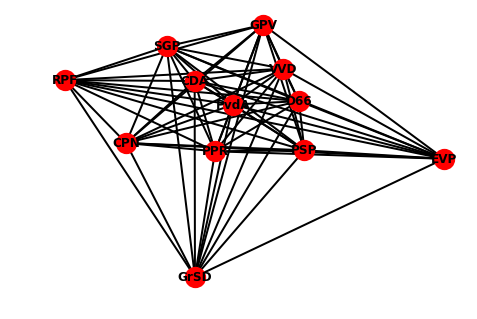

In [10]:
%matplotlib inline

# plot graph
nx.draw(G, with_labels=True, linewidths=4, font_weight="bold", width=2)
plt.show()

In [11]:
# make a new graph with random node positions
H = nx.random_geometric_graph(len(parties), 0.125)
positions_dict = nx.get_node_attributes(H, "pos")
positions = [positions_dict[node] for node in positions_dict]

# apply all random positions to the earlier made graph
i = 0
for node in G.nodes:
    G.nodes[node]["pos"] = positions[i]
    i += 1

# Filter edges which are of interest
GL_parties = ["EVP", "PPR", "PSP", "CPN"]
edges_to_remove = []
for edge in G.edges:
    if edge[0] not in GL_parties and edge[1] not in GL_parties:
        edges_to_remove.append(edge)
        
G.remove_edges_from(edges_to_remove)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors

# decide on color scaling
max_weigth = max([node1[1][node2]["weight"] for node1 in G.adjacency() for node2 in node1[1]])
min_weigth = min([node1[1][node2]["weight"] for node1 in G.adjacency() for node2 in node1[1]])

norm = matplotlib.colors.Normalize(vmin=min_weigth, vmax=max_weigth)
cmap = plt.cm.YlGnBu

In [13]:
import plotly.plotly as py
import plotly.graph_objs as go

# make graph in the next 3 cells

pos = nx.get_node_attributes(G, 'pos')

dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x-0.5)**2 + (y-0.5)**2
    if d < dmin:
        ncenter = n
        dmin = d

p = nx.single_source_shortest_path_length(G, ncenter)

In [14]:
from copy import deepcopy

data = []

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=2, 
              color='#000', 
              ),
    hoverinfo='text',
    mode='lines')


for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] = (x0, (x0+x1)/2, x1, None)
    edge_trace['y'] = (y0, (y0+y1)/2, y1, None)
    edge_info = '{}, {}: {}'.format(edge[0], edge[1], G[edge[0]][edge[1]]["weight"])
    edge_trace['text'] = edge_info
    r, g, b, _ = cmap(norm(G[edge[0]][edge[1]]["weight"]))
    color = "rgb({}, {}, {})".format(r, g, b)
    edge_trace['line']['color'] = color
    data.append(deepcopy(edge_trace))

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale="YlGnBu", 
        reversescale=True, 
        colorbar=dict(
                  thickness=15,
                  title='Edge strength',
                  xanchor='left',
                  titleside='right'
        ),
        color="#000",
        size=15,
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


In [15]:
for node, adjacencies in enumerate(G.adjacency()):
    node_info = 'Party: ' + str(list(G.nodes)[node])
    node_trace['text'] += tuple([node_info])

In [16]:
data.append(node_trace)

fig = go.Figure(data=data,
             layout=go.Layout(
                title='<br>Network graph GL 1981-1989 <br> <br> Every node represents a party and every edge represents the amount of collaborations',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=100),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='GL-plot', auto_open=True)

/opt/tljh/user/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

